In [1]:


#!pip install pymc3 --upgrade  # This must be called every first run
#!pip install PyAstronomy

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm
from PyAstronomy import pyasl

import numpy as np
import scipy
import pymc3 as pm

from google.colab import drive
drive.mount('/content/drive')



#  Ballesteros' formula, function for BV given T

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
##### OPTIONS #####

map = 1       # 1 - use find map, 0 - sample 
samples = 500  #if sampling, this is the number that decides the sampling and tuning
tune = 1000

opt_params = 0   # if 1 use predetermined values

errorbars = 0   # plot error bars on surface plot 
smp_rt = 1      # every nth point of true data
num_gen =400 # given n will produce n x n points of predictions




data = np.genfromtxt('/content/drive/My Drive/data/data1.csv', delimiter=',', skip_header=1)
#!pip install pymc3 --upgrade  # This must be called every first run

Teff = data[:,0][0::smp_rt] # Teff
Prot = data[:, 1][0::smp_rt]  # Prot
Age = data[:, 2][0::smp_rt]  # Age 
Mass = data[:, 3][0::smp_rt]   # mass
b = pyasl.BallesterosBV_T()
BV =  b.bv2T(np.array(Teff))


In [4]:
'''b = pyasl.BallesterosBV_T()'''


'b = pyasl.BallesterosBV_T()'

# Age 

[10.92873499  0.53712399]


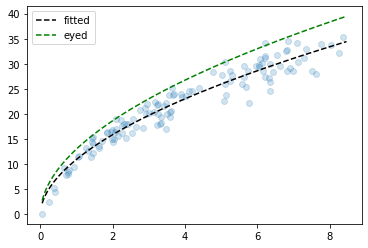

In [5]:


limit = (np.where(np.logical_and(Mass>0.9, Mass<=0.94)))

Teff_short = Teff[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]


plt.scatter(Age_short, Prot_short, alpha=0.2)



coefs = scipy.optimize.curve_fit(lambda t,a,c: a*t**c,  Age_short,  Prot_short, p0=(10,0.5))
print(coefs[0])

x = np.linspace(np.amin(Age),np.amax(Age),1000)
y1 = coefs[0][0]* x **coefs[0][1]
y2 = 13*x**0.52
plt.plot(x,y1, color='k', linestyle='--', label='fitted')
plt.plot(x,y2, color='g', linestyle='--', label='eyed')
plt.legend()



In [6]:
A = coefs[0][0]
c = coefs[0][1]
X = np.array([Age, Mass]).T 

with pm.Model() as model:

    A_ = pm.Normal('A_', A, A*0.5)
    c_ = pm.Normal('c_', c, c*0.3)
    mean = A_ * Age**c_

    l1 = pm.Lognormal('l1', mu=np.log(14.0), sigma=0.01)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(0.1), sigma=0.01)
    
    resid = Prot - mean

    sf2 = pm.Lognormal("sf2", mu=np.log(15), sigma=1)
    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=1)
    

    K1 = pm.gp.cov.ExpQuad(1, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(1, l2) * sf2**2
    K = K1 * K2
    
    #n = pm.Lognormal('n', np.log(4), 1.0)
    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X, y=resid, noise=1.0)

    mp = pm.find_MAP()


/usr/local/lib/python3.6/dist-packages/pymc3/gp/cov.py:93: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  " the number of columns to use. Ignore otherwise.", UserWarning)
/usr/local/lib/python3.6/dist-packages/pymc3/gp/cov.py:93: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  " the number of columns to use. Ignore otherwise.", UserWarning)
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics lib

{'A_': array(9.62845932), 'c_': array(0.58878715), 'l1_log__': array(2.63890858), 'l2_log__': array(-2.3714037), 'sf2_log__': array(1.39835373), 'sf1_log__': array(1.39835377), 'l1': array(13.99791772), 'l2': array(0.0933496), 'sf2': array(4.04852949), 'sf1': array(4.04852965)}


/usr/local/lib/python3.6/dist-packages/pymc3/gp/cov.py:93: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  " the number of columns to use. Ignore otherwise.", UserWarning)


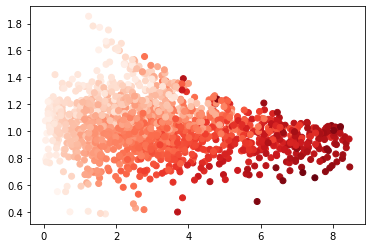

9.628459323538063 0.5887871494178741


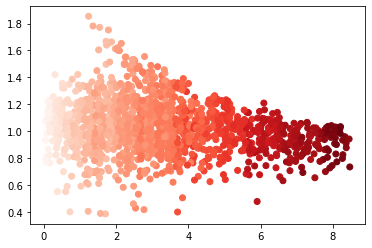

In [7]:
print(mp)
A = mp['A_']
c = mp['c_']

age_new = np.random.rand(400) * 8
mass_new = np.random.rand(400) * 1.0 + 0.4
Xnew = np.array([age_new, mass_new]).T
mu, var = gp.predict(X, point=mp, diag=True, pred_noise=True)




plt.scatter(Age, Mass, c=Prot, cmap='Reds')
plt.show()
plt.scatter(Age, Mass, c = mp['A_'] * Age**mp['c_'] + mu, cmap='Reds')

print(A, c)




[20.26718373 -1.14331942]


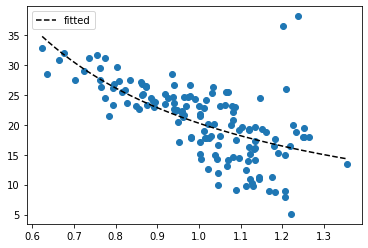

In [8]:
limit = (np.where(np.logical_and(Age>4, Age<=5)))

Teff_short = Teff[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]



plt.scatter(Mass_short, Prot_short)


coefs2 = scipy.optimize.curve_fit(lambda t,a,c: a*t**c,  Mass_short,  Prot_short)
print(coefs2[0])

x = np.linspace(np.amin(Mass_short),np.amax(Mass_short),1000)
y1 = coefs2[0][0]* x **coefs2[0][1]

plt.plot(x,y1, color='k', linestyle='--', label='fitted')
plt.legend()


In [31]:
B = coefs2[0][0]
d = coefs2[0][1]


A = A
c = c

X = np.array([Age, Mass]).T 

with pm.Model() as model:

    A_ = pm.Normal('A_', A, A*0.5)


    c_ = pm.Normal('c_', c, c*0.01)
    



    d_ = pm.Normal('d_', d, d*0.03)


    #d_ = d
    #c_ = c
    #A_ = A
     

    mean = A_ * Age**c_   * Mass **d_

    l1 = pm.Lognormal('l1', mu=np.log(14.0), sigma=0.11)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(0.1), sigma=0.11)
    
    resid = Prot - mean

    sf2 = pm.Lognormal("sf2", mu=np.log(15), sigma=1)
    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=1)
    

    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2
    K = K1 * K2
    
    n = pm.HalfCauchy("n", beta=3)

    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X, y=resid, noise=n)

    mp = pm.find_MAP()
 

In [21]:
print(mp)

{'A_': array(9.62841885), 'c_': array(0.58823039), 'd_': array(-1.14305371), 'l1_log__': array(2.63798435), 'l2_log__': array(-3.06662932), 'sf2_log__': array(2.25185129), 'sf1_log__': array(2.25185129), 'l1': array(13.98498628), 'l2': array(0.04657789), 'sf2': array(9.50531668), 'sf1': array(9.50531668)}


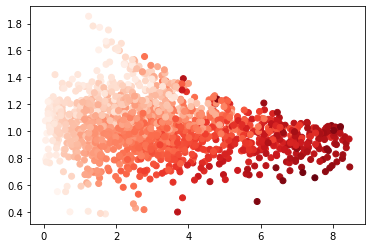

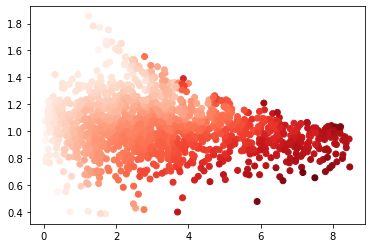

In [35]:

## try and predict outside of age range. 

mu, var = gp.predict(X, point=mp, diag=True, pred_noise=False)


mean = mp['A_'] * Age**mp['c_']    * Mass **(mp['d_'])

plt.scatter(Age, Mass, c=Prot, cmap='Reds')
plt.show()

plt.scatter (Age, Mass, c = mean + mu , cmap='Reds')

(1450,)
(1450,)
[-0.69237652 -1.84023472 -2.08211747 ... -1.93913701 -3.20873973
 -1.71030306]
(2, 1450)


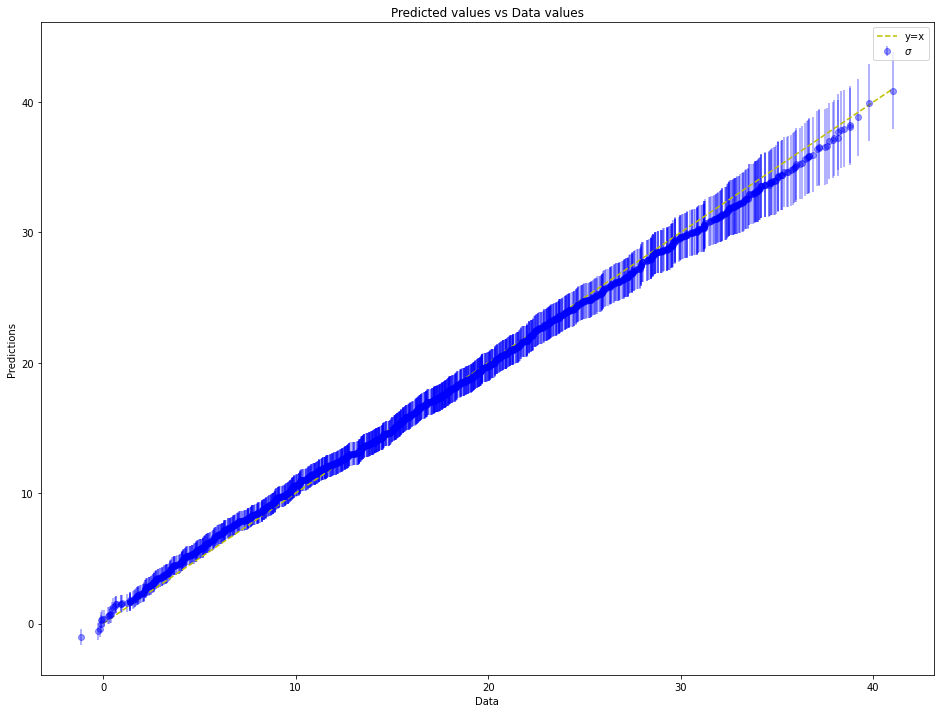

In [36]:
sd = np.sqrt(var)
ydata = Prot
num_gen = len(Mass)
numElems = len(ydata)
print(mu.shape)
print(Mass.shape)
print(mu)

# Picks equal spaced elements from (longer) prediction array so that its shape of data


y_pred = mean + mu
mu_test = (y_pred)
sd_test = sd
 

vals = np.sort([mu_test, sd_test], axis=1)
print(vals.shape)

# sorts them together :) 

fig = plt.figure(figsize=(16, 12))

plt.plot([0, max(Prot)], [0, max(Prot)], linestyle='--', label='y=x', color='y')
plt.errorbar(np.sort(Prot), vals[0,:], yerr=vals[1,:], fmt='o', label=r'$\sigma$', color='b', alpha=0.4)


plt.xlabel("Data")
plt.ylabel("Predictions")
plt.title("Predicted values vs Data values")
plt.legend()

Fitted the Age vs Prot using a function form of $P \propto aT^b$
Fitting numerically I deteremind $a= 7.01, b = 0.75$
However, fitting by eye and incorpoating prior knowledge, I determined values of $a = 13, b = 0.52$

0.8646042885253085


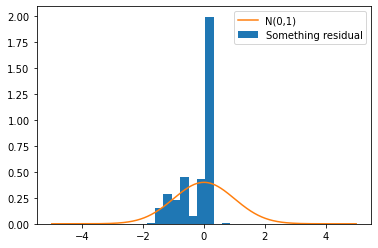

In [38]:
Z = (np.sort(ydata) - vals[0, :])/(vals[1, :])**2



x = np.linspace(-5,5, 1000)
f = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 

plt.hist(Z, density=True, label='Something residual')
 
plt.plot(x,f, label='N(0,1)')
plt.legend()